In [ ]:
import os, sys
import numpy as np
import scipy.io as sio
from skimage import io
import skimage.transform
import matplotlib.pyplot as plt

sys.path.append('..')
import open3d as o3d
import trimesh

import face3d.face3d as face3d

from face3d.face3d import mesh
from face3d.face3d.morphable_model import MorphabelModel

import ipywidgets as widgets
from scipy.spatial import cKDTree

: 

In [3]:
mat_path = 'face3d/examples/Data/300W_LP/AFW/AFW_134212_1_0.mat'
prnet_obj_path = 'predictions/test/AFW_134212_1_0.obj'
bfm = MorphabelModel('face3d/examples/Data/BFM/Out/BFM.mat')

In [361]:
info = sio.loadmat(mat_path)
pose_para = info['Pose_Para'].T.astype(np.float32)
shape_para = info['Shape_Para'].astype(np.float32)
exp_para = info['Exp_Para'].astype(np.float32)
vertices = bfm.generate_vertices(shape_para, exp_para)
faces = bfm.full_triangles
face_center = np.mean(vertices, axis=0)
center_x, center_y, center_z = face_center[0], face_center[1], face_center[2]

y_min_index = np.argmin(vertices[:, 1])
vertex_at_y_min = vertices[y_min_index]

# Extract the z-value of this vertex
z_offset = vertex_at_y_min[2] - center_z

center_z += z_offset

In [229]:
def get_vertices_from_obj(file_path):
    vertices = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('v '):  # Vertex description line
                parts = line.split()
                if len(parts) >= 4:  # Ensure there are at least 4 parts
                    _, x, y, z = parts[:4]  # Take only the first four elements
                    vertices.append([float(x), float(y), float(z)])
    return vertices

prn_vertices = get_vertices_from_obj(prnet_obj_path)


In [342]:
prn_vertices = np.asarray(prn_vertices)
filtered_prn_vertices = prn_vertices[prn_vertices[:,2] >= 75]
filtered_prn_vertices = filtered_prn_vertices[filtered_prn_vertices[:,1] <= 260]

In [343]:
# Calculate y_max - y_min for filtered_prn_vertices
prn_y_max = np.max(filtered_prn_vertices[:, 1])
prn_y_min = np.min(filtered_prn_vertices[:, 1])
prn_span = prn_y_max - prn_y_min

# Calculate y_max - y_min for filtered_vertices
filtered_y_max = np.max(filtered_vertices[:, 1])
filtered_y_min = np.min(filtered_vertices[:, 1])
filtered_span = filtered_y_max - filtered_y_min

# Determine the scaling factor
scaling_factor = filtered_span / prn_span

# Apply the scaling uniformly to all coordinates of filtered_prn_vertices
scaled_prn_vertices = filtered_prn_vertices * scaling_factor

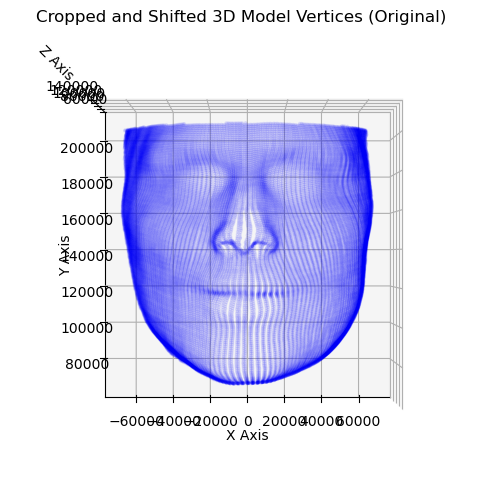

In [344]:
# Plotting the cropped vertices
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Assuming reconstructed_vertices contains [x, y, z] coordinates
ax.scatter(scaled_prn_vertices[:,0], scaled_prn_vertices[:,1], scaled_prn_vertices[:,2], color='blue', s=3, alpha=0.08)

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('Cropped and Shifted 3D Model Vertices (Original)')
ax.view_init(elev=90, azim=270)
plt.show()

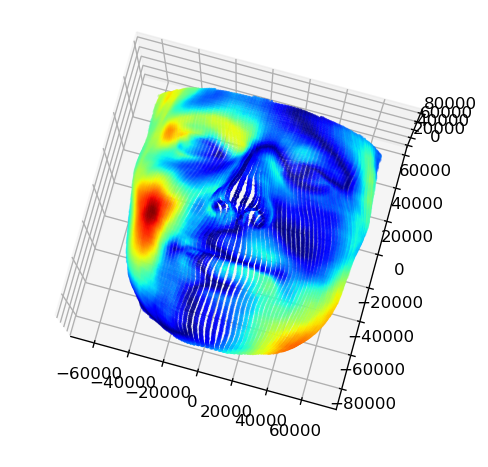

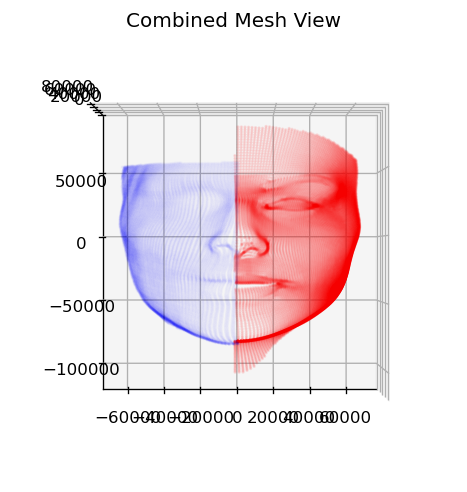

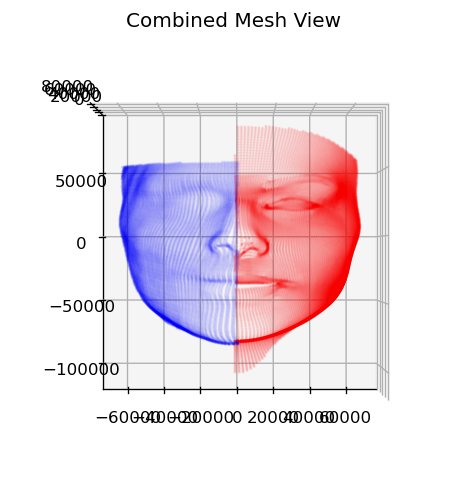

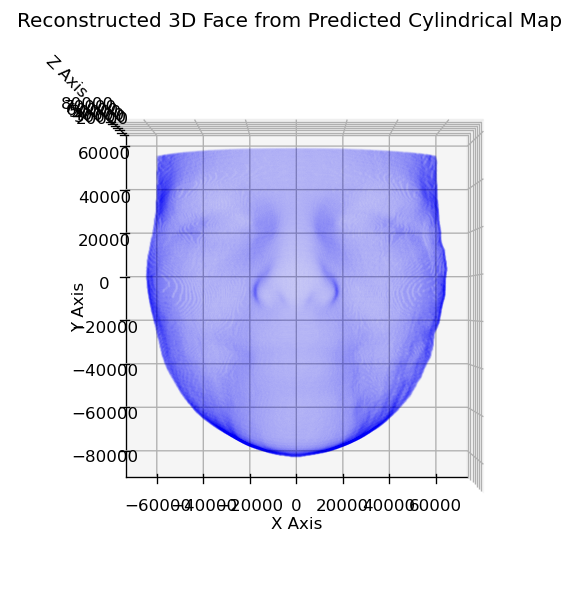

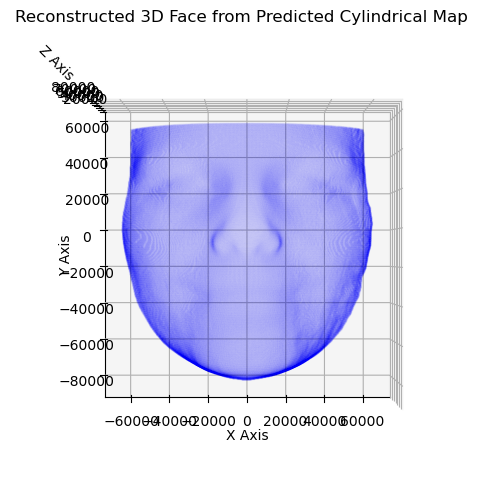

In [359]:
%matplotlib inline
# Plotting the reconstructed vertices
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Assuming reconstructed_vertices contains [x, y, z] coordinates
ax.scatter(filtered_vertices[:,0], filtered_vertices[:,1], filtered_vertices[:,2], color='blue', s=0.5, alpha=0.03)

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('Reconstructed 3D Face from Predicted Cylindrical Map')
# ax.view_init(elev=90, azim=270)
ax.view_init(elev=90, azim=270)
plt.show()

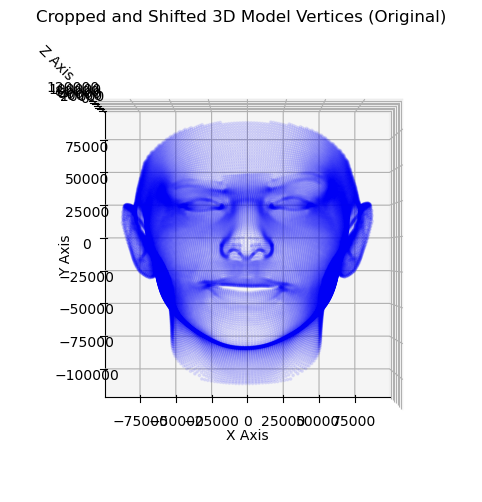

In [346]:
# Plotting the cropped vertices
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Assuming reconstructed_vertices contains [x, y, z] coordinates
ax.scatter(vertices[:,0], vertices[:,1], vertices[:,2], color='blue', s=3, alpha=0.08)

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('Cropped and Shifted 3D Model Vertices (Original)')
ax.view_init(elev=90, azim=270)
plt.show()

In [209]:
def crop_and_shift_mesh(vertices, faces, z_offset):
    """
    Efficiently crop a mesh at a specified Z offset and shift it to z=0.

    :param vertices: Nx3 numpy array of vertices.
    :param faces: Mx3 numpy array of faces (indices into vertices).
    :param z_offset: Z value at which to crop the mesh.
    :return: Cropped and shifted vertices and faces.
    """
    # Filter vertices below the z_offset
    valid_vertices_mask = vertices[:, 2] >= z_offset
    cropped_vertices = vertices[valid_vertices_mask]

    # Shift the mesh so the base lies at z=0
    min_z = np.min(cropped_vertices[:, 2])
    cropped_vertices[:, 2] -= min_z

    # Normalize along the y-axis
    # y_max = np.max(cropped_vertices[:, 1])
    # y_min = np.min(cropped_vertices[:, 1])
    # y_range = y_max - y_min
    # cropped_vertices[:, 1] = (cropped_vertices[:, 1] - y_min) / y_range

    # # # Apply the same scale factor to x and z coordinates
    # scale_factor = 1 / y_range
    # cropped_vertices[:, 0] *= scale_factor
    # cropped_vertices[:, 2] *= scale_factor

    # Create a mapping from old vertex indices to new indices
    index_mapping = np.full(vertices.shape[0], -1, dtype=int)
    index_mapping[valid_vertices_mask] = np.arange(cropped_vertices.shape[0])

    # Update faces
    mapped_faces = index_mapping[faces]
    valid_faces_mask = np.all(mapped_faces >= 0, axis=1)
    cropped_faces = mapped_faces[valid_faces_mask]

    return cropped_vertices, cropped_faces

cropped_vertices, cropped_faces = crop_and_shift_mesh(vertices, faces, center_z)

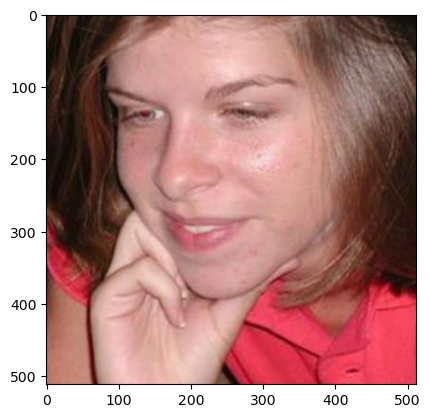

In [210]:
%matplotlib inline
image_path = 'predictions/test/AFW_134212_1_0.jpg'
image = io.imread(image_path)/255.
plt.imshow(image)
plt.show()

In [381]:
prediction_file = 'predictions/test/AFW_134212_1_0_prediction.npy'
predicted_posmap = np.load(prediction_file)
predicted_posmap = predicted_posmap.squeeze()
predicted_posmap.shape
predicted_posmap = (predicted_posmap - predicted_posmap.min()) / (predicted_posmap.max() - predicted_posmap.min())  # Normalize to [0, 1]
predicted_posmap = (predicted_posmap * 255).astype(np.uint8)

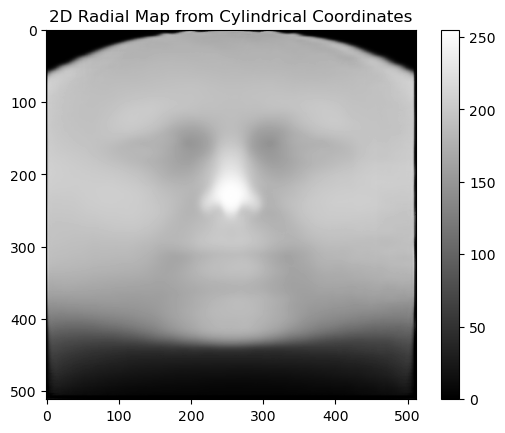

In [382]:
plt.imshow(predicted_posmap, cmap='gray')
plt.colorbar()
plt.title("2D Radial Map from Cylindrical Coordinates")
plt.show()

In [375]:
true_posmap_file = 'predictions/test/AFW_134212_1_0.npz'
true_posmap = np.load(true_posmap_file)[list(np.load(true_posmap_file).keys())[0]]
true_posmap = true_posmap.squeeze()
scale_factor = true_posmap.max() - true_posmap.min()
# true_posmap = (true_posmap - true_posmap.min()) / scale_factor  # Normalize to [0, 1]
# true_posmap = (true_posmap * 255).astype(np.uint8)

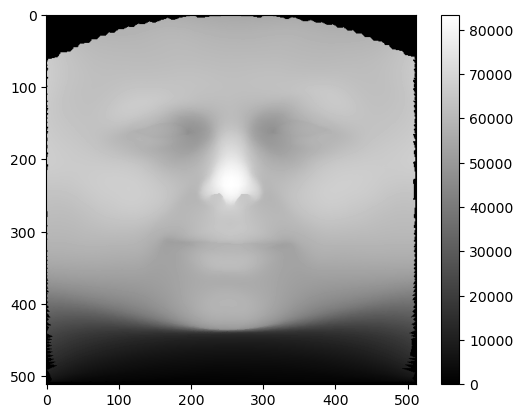

In [379]:
plt.imshow(true_posmap, cmap='gray')
plt.colorbar()
# plt.title("2D Radial Map from Cylindrical Coordinates")
plt.show()

In [389]:
predicted_posmap_norm = predicted_posmap / 255.
# Pre-calculate constants
phi_values = (np.arange(512) / (512 - 1)) * np.pi - np.pi / 2
y_max = np.max(vertices[:, 1])
y_min = np.min(vertices[:, 1])
y_values = y_max - (np.arange(512) / (512 - 1)) * (y_max - y_min)

# Create mesh grids for phi and y
phi_grid, y_grid = np.meshgrid(phi_values, y_values)

# Flatten and filter out zero-radius points
valid_indices = predicted_posmap_norm != 0
r_flat = (predicted_posmap_norm[valid_indices] * scale_factor) + true_posmap.min()
phi_flat = phi_grid[valid_indices]
y_flat = y_grid[valid_indices]

# Convert back to Cartesian coordinates
x = r_flat * np.sin(phi_flat)
z = r_flat * np.cos(phi_flat)

# Combine the coordinates
reconstructed_prediction = np.vstack((x, y_flat, z)).T

In [390]:
filtered_vertices = reconstructed_prediction[reconstructed_prediction[:,2] >= 20000]
filtered_vertices = filtered_vertices[filtered_vertices[:,1] <= 55000]

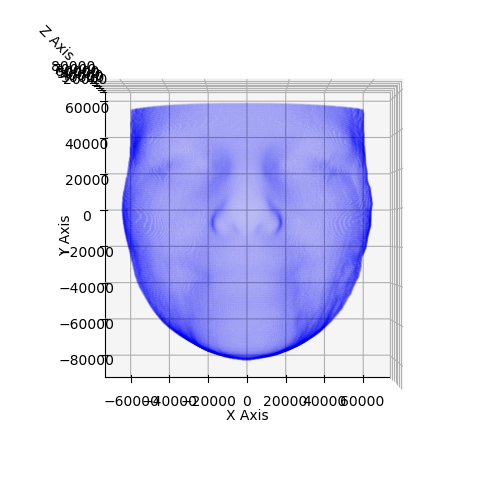

In [409]:
# Plotting the reconstructed vertices
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Assuming reconstructed_vertices contains [x, y, z] coordinates
ax.scatter(filtered_vertices[:,0], filtered_vertices[:,1], filtered_vertices[:,2], color='blue', s=0.5, alpha=0.04)

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
# ax.set_title('Reconstructed 3D Face from Predicted Cylindrical Map')
ax.view_init(elev=90, azim=270)
# ax.view_init(elev=90, azim=270)
plt.show()

In [178]:
# Pre-calculate constants
phi_values = (np.arange(512) / (512 - 1)) * np.pi - np.pi / 2
y_max = np.max(vertices[:, 1])
y_min = np.min(vertices[:, 1])
y_values = y_max - (np.arange(512) / (512 - 1)) * (y_max - y_min)

# Create mesh grids for phi and y
phi_grid, y_grid = np.meshgrid(phi_values, y_values)

# Flatten and filter out zero-radius points
valid_indices = true_posmap != 0
r_flat = true_posmap[valid_indices]
phi_flat = phi_grid[valid_indices]
y_flat = y_grid[valid_indices]

# Convert back to Cartesian coordinates
x = r_flat * np.sin(phi_flat)
z = r_flat * np.cos(phi_flat)

# Combine the coordinates
reconstructed_gt = np.vstack((x, y_flat, z)).T

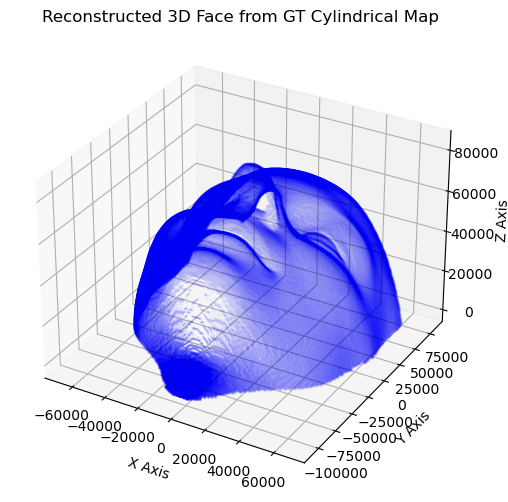

In [234]:
# Plotting the reconstructed vertices
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Assuming reconstructed_vertices contains [x, y, z] coordinates
ax.scatter(reconstructed_gt[:,0], reconstructed_gt[:,1], reconstructed_gt[:,2], color='blue', s=1, alpha=0.03)

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('Reconstructed 3D Face from GT Cylindrical Map')
# ax.view_init(elev=90, azim=270)
# ax.view_init(elev=90, azim=270)
plt.show()

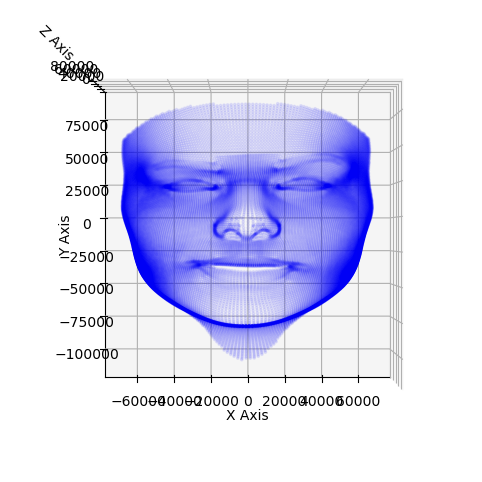

In [380]:
# Plotting the cropped vertices
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Assuming reconstructed_vertices contains [x, y, z] coordinates
ax.scatter(cropped_vertices[:,0], cropped_vertices[:,1], cropped_vertices[:,2], color='blue', s=3, alpha=0.08)

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
# ax.set_title('Cropped and Shifted 3D Model Vertices (Original)')
ax.view_init(elev=90, azim=270)
plt.show()

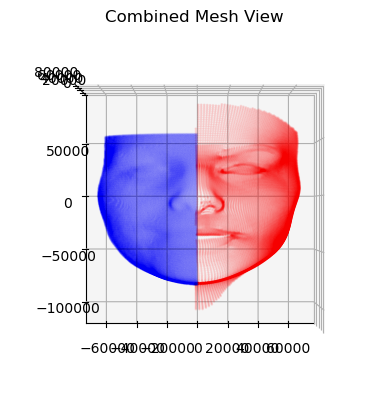

In [211]:
# Assuming scaled_reconstructed and scaled_shifted are already defined
# Split the models in half (modify the condition as per your model's orientation)
half_index_reconstructed = np.median(filtered_vertices[:, 0])
half_index_shifted = np.median(cropped_vertices[:, 0])

# Use only half of each model
half_reconstructed = filtered_vertices[filtered_vertices[:, 0] <= half_index_reconstructed]
half_shifted = cropped_vertices[cropped_vertices[:, 0] > half_index_shifted]

# Combine the halves
combined_vertices = np.vstack((half_reconstructed, half_shifted))

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the combined mesh
ax.scatter(half_reconstructed[:, 0], half_reconstructed[:, 1], half_reconstructed[:, 2], s=1, alpha=0.02, color='blue')
ax.scatter(half_shifted[:, 0], half_shifted[:, 1], half_shifted[:, 2], s=1, alpha=0.1, color='red')

# Set the view angle
ax.view_init(elev=90, azim=270)

ax.set_title("Combined Mesh View")

plt.show()

In [387]:
def calculate_point_to_surface_distances(mesh_vertices, mesh_faces, point_cloud):
    # Create a trimesh object from the mesh
    mesh = trimesh.Trimesh(vertices=mesh_vertices, faces=mesh_faces, process=False)

    # Use trimesh's nearest.on_surface to find the closest point on the mesh for each point in the point cloud
    closest_points, distances, _ = trimesh.proximity.closest_point(mesh, point_cloud)

    return distances

In [392]:
distances = calculate_point_to_surface_distances(cropped_vertices, cropped_faces, filtered_vertices)

In [217]:
def calculate_NME(distances, y_max, y_min):
    normalization_factor = y_max - y_min
    mean_error = np.mean(distances)
    nme_percent = (mean_error / normalization_factor) * 100
    return nme_percent

y_max = max([point[1] for point in cropped_vertices])
y_min = min([point[1] for point in cropped_vertices])
nme_percent = calculate_NME(distances, y_max, y_min)
print("NME: {}%".format(nme_percent))

NME: 0.37343700629871185%


In [214]:
# Calculate statistics
mean_distance = np.mean(distances)
median_distance = np.median(distances)
std_distance = np.std(distances)
hausdorff_distance = distances.max()

print(f"Mean Distance: {mean_distance}")
print(f"Median Distance: {median_distance}")
print(f"Standard Deviation: {std_distance}")
print(f"Hausdorff Distance: {hausdorff_distance}")

Mean Distance: 708.1508706760044
Median Distance: 565.1282939896605
Standard Deviation: 635.5254383139185
Hausdorff Distance: 4980.641398869256


In [6]:
def calculate_normalized_distances(mesh_vertices, mesh_faces, point_cloud, y_max, y_min):
    # Create a trimesh object from the mesh
    mesh = trimesh.Trimesh(vertices=mesh_vertices, faces=mesh_faces, process=False)

    # Use trimesh's nearest.on_surface to find the closest point on the mesh for each point in the point cloud
    closest_points, distances, _ = trimesh.proximity.closest_point(mesh, point_cloud)

    # Normalize the distances
    normalization_factor = y_max - y_min
    normalized_distances = distances / normalization_factor

    return normalized_distances

In [400]:
normalized_distances = calculate_normalized_distances(cropped_vertices, cropped_faces, filtered_vertices, y_max, y_min)
# Calculate the mean distance
normalized_mean_distance = np.mean(normalized_distances) * 100
# Calculate the median distance
normalized_median_distance = np.median(normalized_distances) * 100
# Calculate the standard deviation of the distances
normalized_std_distance = np.std(normalized_distances) * 100
# Calculate the Hausdorff distance, which is the maximum distance in the array
normalized_hausdorff_distance = np.max(normalized_distances) * 100

# Print the calculated statistics with descriptive messages
print(f"Mean Normalized Distance %: {normalized_mean_distance:.4f}")  # Rounded to 4 decimal places for clarity
print(f"Median Normalized Distance %: {normalized_median_distance:.4f}")  # Same rounding applied
print(f"Standard Deviation of Normalized Distances %: {normalized_std_distance:.4f}")
print(f"Hausdorff Distance (Max Normalized Distance) %: {normalized_hausdorff_distance:.4f}")

Mean Normalized Distance %: 0.3734
Median Normalized Distance %: 0.2980
Standard Deviation of Normalized Distances %: 0.3351
Hausdorff Distance (Max Normalized Distance) %: 2.6265


In [215]:
gt_distances = calculate_point_to_surface_distances(cropped_vertices, cropped_faces, reconstructed_gt)

In [218]:
y_max = max([point[1] for point in cropped_vertices])
y_min = min([point[1] for point in cropped_vertices])
nme_percent = calculate_NME(gt_distances, y_max, y_min)
print("NME: {}%".format(nme_percent))

NME: 0.14240048086143367%


In [137]:
# Calculate statistics
mean_distance = np.mean(gt_distances)
median_distance = np.median(gt_distances)
std_distance = np.std(gt_distances)
hausdorff_distance = gt_distances.max()

print(f"Mean Distance: {mean_distance}")
print(f"Median Distance: {median_distance}")
print(f"Standard Deviation: {std_distance}")
print(f"Hausdorff Distance: {hausdorff_distance}")

Mean Distance: 270.03489961046694
Median Distance: 267.3540996777605
Standard Deviation: 144.43520839271392
Hausdorff Distance: 742.9113047144245


In [404]:
normalized_distances = calculate_normalized_distances(cropped_vertices, cropped_faces, reconstructed_gt, y_max, y_min)
# Calculate the mean distance
normalized_mean_distance = np.mean(normalized_distances) * 100
# Calculate the median distance
normalized_median_distance = np.median(normalized_distances) * 100
# Calculate the standard deviation of the distances
normalized_std_distance = np.std(normalized_distances) * 100
# Calculate the Hausdorff distance, which is the maximum distance in the array
normalized_hausdorff_distance = np.max(normalized_distances) * 100

# Print the calculated statistics with descriptive messages
print(f"Mean Normalized Distance %: {normalized_mean_distance:.4f}")  # Rounded to 4 decimal places for clarity
print(f"Median Normalized Distance %: {normalized_median_distance:.4f}")  # Same rounding applied
print(f"Standard Deviation of Normalized Distances %: {normalized_std_distance:.4f}")
print(f"Hausdorff Distance (Max Normalized Distance) %: {normalized_hausdorff_distance:.4f}")

Mean Normalized Distance %: 0.1424
Median Normalized Distance %: 0.1410
Standard Deviation of Normalized Distances %: 0.0762
Hausdorff Distance (Max Normalized Distance) %: 0.3918


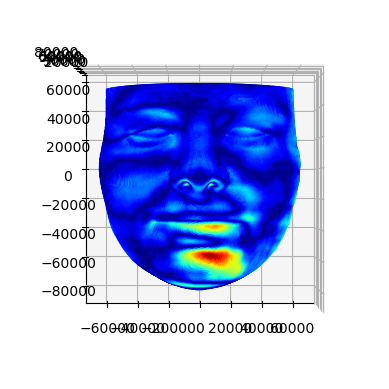

In [403]:
%matplotlib inline

normalized_distances = (distances - np.min(distances)) / (np.max(distances) - np.min(distances))

# Create a scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(filtered_vertices[:, 0], filtered_vertices[:, 1], filtered_vertices[:, 2], c=normalized_distances, cmap='jet', s=0.5)
ax.view_init(elev=90, azim=270)
plt.show()

In [347]:
# Calculate y_max and y_min for scaled_prn_vertices
scaled_prn_y_max = np.max(scaled_prn_vertices[:, 1])
scaled_prn_y_min = np.min(scaled_prn_vertices[:, 1])

# Calculate y_max and y_min for filtered_vertices
filtered_y_max = np.max(filtered_vertices[:, 1])
filtered_y_min = np.min(filtered_vertices[:, 1])

# Calculate the vertical offset
vertical_offset = filtered_y_min - scaled_prn_y_min

# Translate scaled_prn_vertices vertically
aligned_prn_vertices = scaled_prn_vertices.copy()
aligned_prn_vertices[:, 1] += vertical_offset

# Calculate the maximum Z-value for both point clouds
max_z_prn = np.max(aligned_prn_vertices[:, 2])
max_z_filtered = np.max(filtered_vertices[:, 2])

# Calculate the Z-axis offset
z_offset = max_z_filtered - max_z_prn

# Translate aligned_prn_vertices vertically and in Z-axis
aligned_prn_vertices[:, 2] += z_offset

# Find the index of the point with the maximum Z-value in both point clouds
index_max_z_prn = np.argmax(aligned_prn_vertices[:, 2])
index_max_z_filtered = np.argmax(filtered_vertices[:, 2])

# Get the X-coordinate of the point with the maximum Z-value in both point clouds
x_max_z_prn = aligned_prn_vertices[index_max_z_prn, 0]
x_max_z_filtered = filtered_vertices[index_max_z_filtered, 0]

# Calculate the X-axis offset
x_offset = x_max_z_filtered - x_max_z_prn

# Translate aligned_prn_vertices in X-axis
aligned_prn_vertices[:, 0] += x_offset

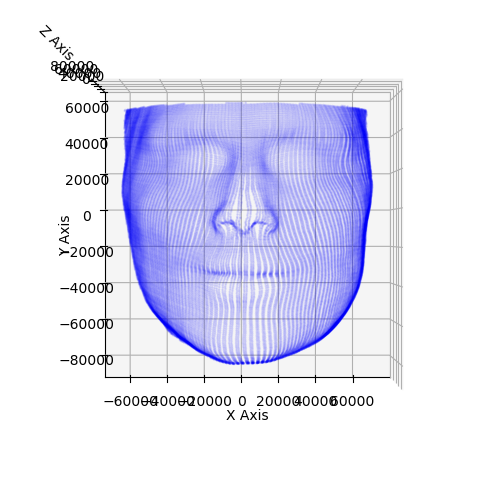

In [408]:
# Plotting the reconstructed vertices
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Assuming reconstructed_vertices contains [x, y, z] coordinates
ax.scatter(aligned_prn_vertices[:,0], aligned_prn_vertices[:,1], aligned_prn_vertices[:,2], color='blue', s=1, alpha=0.1)

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
# ax.set_title('Reconstructed 3D Face from Predicted Cylindrical Map')
ax.view_init(elev=90, azim=270)
# ax.view_init(elev=90, azim=270)
plt.show()

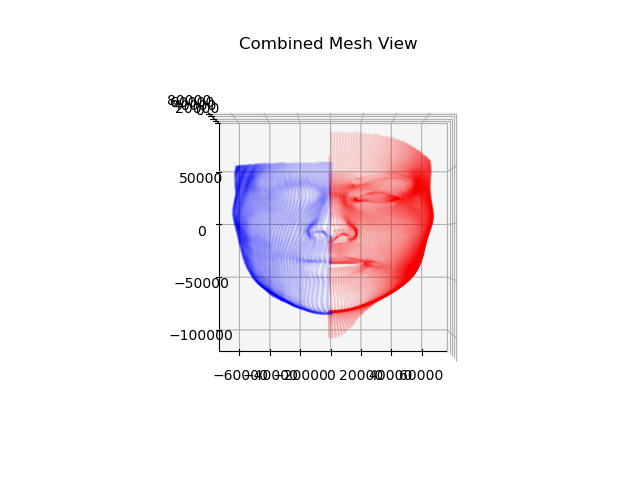

In [357]:
# Assuming scaled_reconstructed and scaled_shifted are already defined
# Split the models in half (modify the condition as per your model's orientation)
half_index_reconstructed = np.median(aligned_prn_vertices[:, 0])
half_index_shifted = np.median(cropped_vertices[:, 0])

# Use only half of each model
half_reconstructed = aligned_prn_vertices[aligned_prn_vertices[:, 0] <= half_index_reconstructed]
half_shifted = cropped_vertices[cropped_vertices[:, 0] > half_index_shifted]

# Combine the halves
combined_vertices = np.vstack((half_reconstructed, half_shifted))

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the combined mesh
ax.scatter(half_reconstructed[:, 0], half_reconstructed[:, 1], half_reconstructed[:, 2], s=1, alpha=0.05, color='blue')
ax.scatter(half_shifted[:, 0], half_shifted[:, 1], half_shifted[:, 2], s=1, alpha=0.1, color='red')

# Set the view angle
ax.view_init(elev=90, azim=270)

ax.set_title("Combined Mesh View")

plt.show()

In [350]:
prn_distances = calculate_point_to_surface_distances(cropped_vertices, cropped_faces, aligned_prn_vertices)

In [351]:
y_max = max([point[1] for point in cropped_vertices])
y_min = min([point[1] for point in cropped_vertices])
nme_percent = calculate_NME(prn_distances, y_max, y_min)
print("NME: {}%".format(nme_percent))

NME: 1.6622232371939822%


In [352]:
# Calculate statistics
mean_distance = np.mean(prn_distances)
median_distance = np.median(prn_distances)
std_distance = np.std(prn_distances)
hausdorff_distance = prn_distances.max()

print(f"Mean Distance: {mean_distance}")
print(f"Median Distance: {median_distance}")
print(f"Standard Deviation: {std_distance}")
print(f"Hausdorff Distance: {hausdorff_distance}")

Mean Distance: 3152.0840538638004
Median Distance: 2977.9831035174316
Standard Deviation: 1816.9140145600734
Hausdorff Distance: 8571.837023807484


In [401]:
normalized_distances = calculate_normalized_distances(cropped_vertices, cropped_faces, aligned_prn_vertices, y_max, y_min)
# Calculate the mean distance
normalized_mean_distance = np.mean(normalized_distances) * 100
# Calculate the median distance
normalized_median_distance = np.median(normalized_distances) * 100
# Calculate the standard deviation of the distances
normalized_std_distance = np.std(normalized_distances) * 100
# Calculate the Hausdorff distance, which is the maximum distance in the array
normalized_hausdorff_distance = np.max(normalized_distances) * 100

# Print the calculated statistics with descriptive messages
print(f"Mean Normalized Distance %: {normalized_mean_distance:.4f}")  # Rounded to 4 decimal places for clarity
print(f"Median Normalized Distance %: {normalized_median_distance:.4f}")  # Same rounding applied
print(f"Standard Deviation of Normalized Distances %: {normalized_std_distance:.4f}")
print(f"Hausdorff Distance (Max Normalized Distance) %: {normalized_hausdorff_distance:.4f}")

Mean Normalized Distance %: 1.6622
Median Normalized Distance %: 1.5704
Standard Deviation of Normalized Distances %: 0.9581
Hausdorff Distance (Max Normalized Distance) %: 4.5203


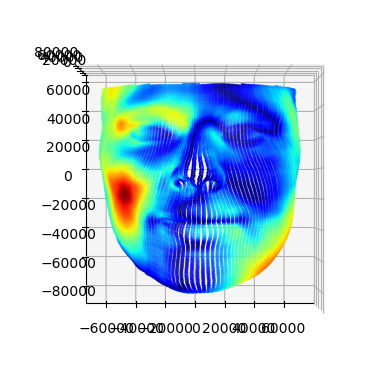

In [405]:
%matplotlib inline
normalized_distances = (prn_distances - np.min(prn_distances)) / (np.max(prn_distances) - np.min(prn_distances))

# Create a scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(aligned_prn_vertices[:, 0], aligned_prn_vertices[:, 1], aligned_prn_vertices[:, 2], c=normalized_distances, cmap='jet', s=0.5)
ax.view_init(elev=90, azim=270)
plt.show()

In [2]:
def convert_to_point_cloud(posmap):
            # Ensure posmap is two-dimensional
            if posmap.ndim == 3 and posmap.shape[2] == 1:
                posmap = posmap[:, :, 0]  # Convert 3D tensor to 2D by removing the channel dimension

            phi_values = (np.arange(512) / (512 - 1)) * np.pi - np.pi / 2
            y_max = 512
            y_min = 0
            y_values = y_max - (np.arange(512) / (512 - 1)) * (y_max - y_min)
            phi_grid, y_grid = np.meshgrid(phi_values, y_values)
            
            valid_indices = posmap != 0
            r_flat = posmap[valid_indices]
            phi_flat = phi_grid[valid_indices]
            y_flat = y_grid[valid_indices]
            
            x = r_flat * np.sin(phi_flat)
            z = r_flat * np.cos(phi_flat)
            point_cloud = np.vstack((x, y_flat, z)).T

            valid_indices = r_flat != 0
            return point_cloud

In [6]:
predicted_posmap_norm = predicted_posmap / 255.
# Pre-calculate constants
phi_values = (np.arange(512) / (512 - 1)) * np.pi - np.pi / 2
y_max = 512
y_min = 0
y_values = y_max - (np.arange(512) / (512 - 1)) * (y_max - y_min)

# Create mesh grids for phi and y
phi_grid, y_grid = np.meshgrid(phi_values, y_values)

# Flatten and filter out zero-radius points
valid_indices = predicted_posmap_norm != 0
r_flat = (predicted_posmap_norm[valid_indices] * scale_factor) + true_posmap.min()
phi_flat = phi_grid[valid_indices]
y_flat = y_grid[valid_indices]

# Convert back to Cartesian coordinates
x = r_flat * np.sin(phi_flat)
z = r_flat * np.cos(phi_flat)

# Combine the coordinates
reconstructed_prediction = np.vstack((x, y_flat, z)).T

In [1]:
prediction_file = 'predictions/test/AFW_134212_1_0_prediction.npy'
predicted_posmap = np.load(prediction_file)
predicted_posmap = predicted_posmap.squeeze()

true_posmap_file = 'predictions/test/AFW_134212_1_0.npz'
true_posmap = np.load(true_posmap_file)[list(np.load(true_posmap_file).keys())[0]]
true_posmap = true_posmap.squeeze()
true_posmap_norm = true_posmap / 255.
predicted_posmap_norm = predicted_posmap / 255.
# predicted_posmap_norm = predicted_posmap
scale_factor = np.ptp(true_posmap_norm)

reconstructed_gt = convert_to_point_cloud(true_posmap_norm)
reconstructed_prediction = convert_to_point_cloud((predicted_posmap * scale_factor) + true_posmap_norm.min()) # 

tree_gt = cKDTree(reconstructed_gt)
distances, _ = tree_gt.query(reconstructed_prediction)
normalization_factor = np.linalg.norm(true_posmap_norm.max() - true_posmap_norm.min())
nme = np.mean(distances) * 100 / normalization_factor
print(nme)

NameError: name 'np' is not defined

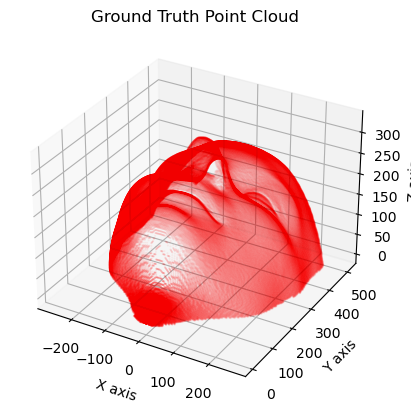

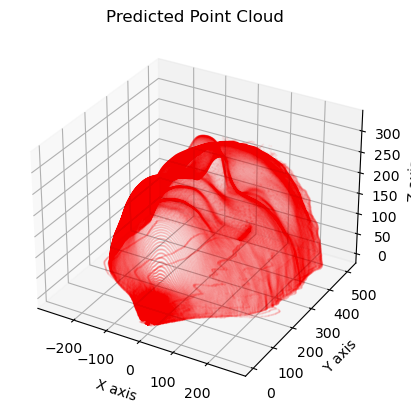

In [37]:
def plot_point_cloud(points, title="Point Cloud"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(points[:, 0], points[:, 1], points[:, 2], marker='.', s=1, c='r', alpha=0.05)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title(title)

    plt.show()

# Visualize the ground truth and prediction
plot_point_cloud(reconstructed_gt, title="Ground Truth Point Cloud")
plot_point_cloud(reconstructed_prediction, title="Predicted Point Cloud")

In [4]:
import open3d as o3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(reconstructed_gt)

pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# Poisson surface reconstruction
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=9)

# Visualize the mesh
# o3d.visualization.draw_geometries([mesh])

In [7]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(reconstructed_gt)
pcd = pcd.voxel_down_sample(voxel_size=0.05)
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# Perform Poisson surface reconstruction
mesh, _ = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=9)

# Get the vertices and faces of the mesh
mesh_vertices = np.asarray(mesh.vertices)
mesh_faces = np.asarray(mesh.triangles)

# Your reconstructed prediction point cloud
# Assuming 'reconstructed_prediction' is available from previous steps

# Calculate y_max and y_min for normalization (based on the mesh or another reference)
y_max = np.max(mesh_vertices[:, 1])  # Assuming Y is the second column in your vertices
y_min = np.min(mesh_vertices[:, 1])

# Calculate normalized distances
normalized_distances = calculate_normalized_distances(mesh_vertices, mesh_faces, reconstructed_prediction, y_max, y_min)


In [ ]:
normalized_mean_distance = np.mean(normalized_distances) * 100
# Calculate the median distance
normalized_median_distance = np.median(normalized_distances) * 100
# Calculate the standard deviation of the distances
normalized_std_distance = np.std(normalized_distances) * 100
# Calculate the Hausdorff distance, which is the maximum distance in the array
normalized_hausdorff_distance = np.max(normalized_distances) * 100

# Print the calculated statistics with descriptive messages
print(f"Mean Normalized Distance %: {normalized_mean_distance:.4f}")  # Rounded to 4 decimal places for clarity
print(f"Median Normalized Distance %: {normalized_median_distance:.4f}")  # Same rounding applied
print(f"Standard Deviation of Normalized Distances %: {normalized_std_distance:.4f}")
print(f"Hausdorff Distance (Max Normalized Distance) %: {normalized_hausdorff_distance:.4f}")

In [39]:
predicted_posmap = np.load('prediction.npy')
predicted_posmap = predicted_posmap.squeeze()
predicted_posmap.shape
predicted_posmap = (predicted_posmap - predicted_posmap.min()) / (predicted_posmap.max() - predicted_posmap.min())  # Normalize to [0, 1]
predicted_posmap = (predicted_posmap * 255).astype(np.uint8)

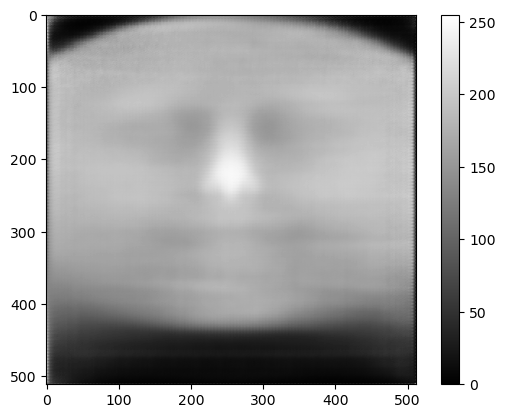

In [40]:
plt.imshow(predicted_posmap, cmap='gray')
plt.colorbar()
# plt.title("2D Radial Map from Cylindrical Coordinates")
plt.show()

Displaying prediction_epoch_1.npy


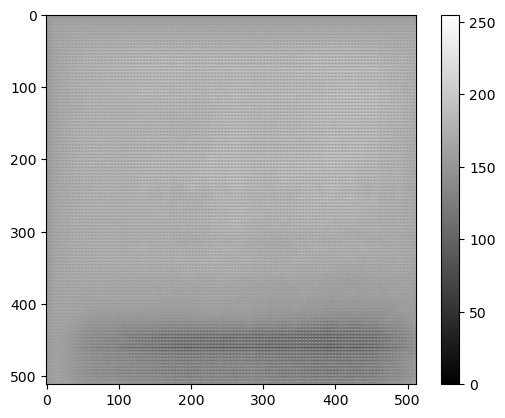

Displaying prediction_epoch_2.npy


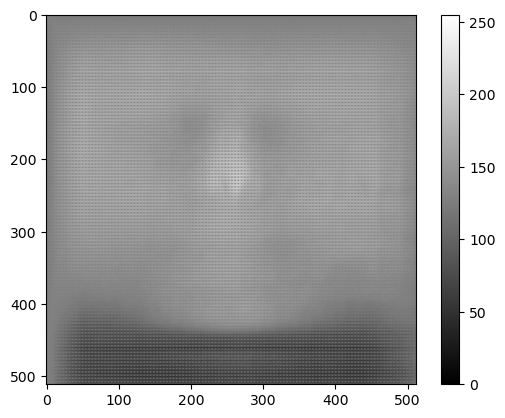

Displaying prediction_epoch_3.npy


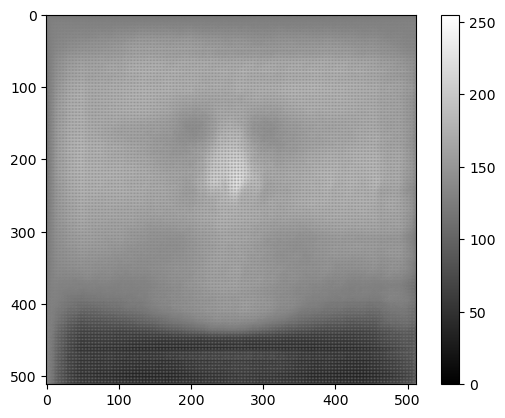

Displaying prediction_epoch_4.npy


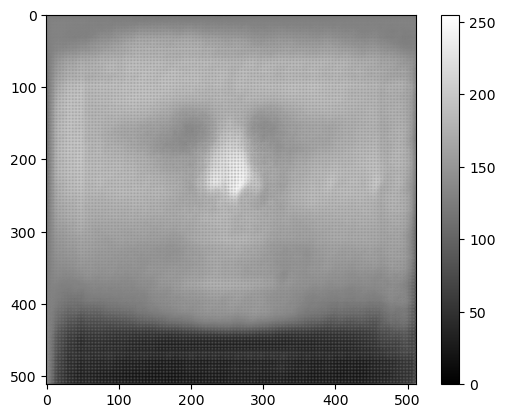

Displaying prediction_epoch_5.npy


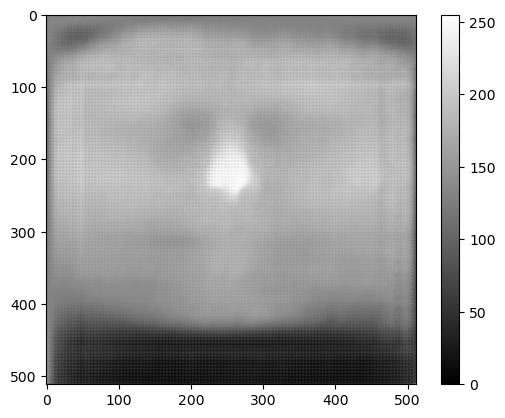

Displaying prediction_epoch_6.npy


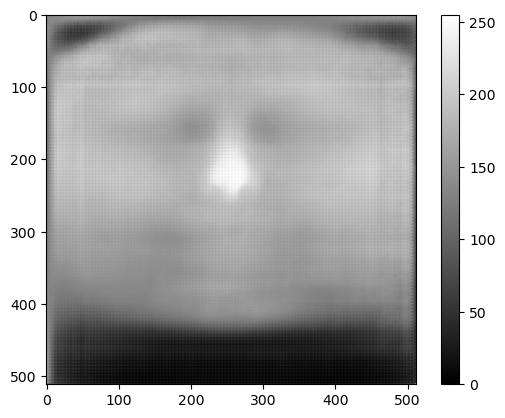

Displaying prediction_epoch_7.npy


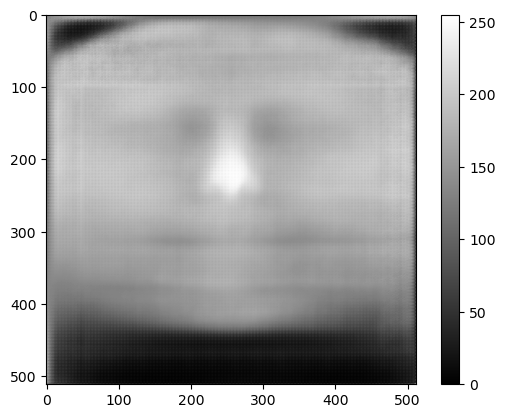

Displaying prediction_epoch_8.npy


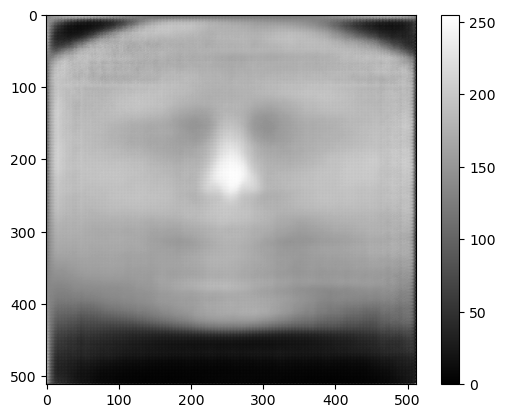

Displaying prediction_epoch_9.npy


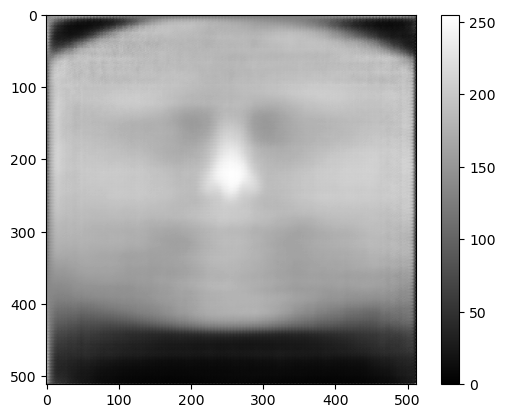

Displaying prediction_epoch_10.npy


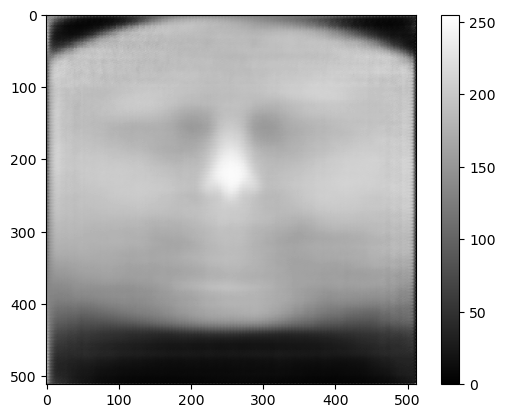

Displaying prediction_epoch_11.npy


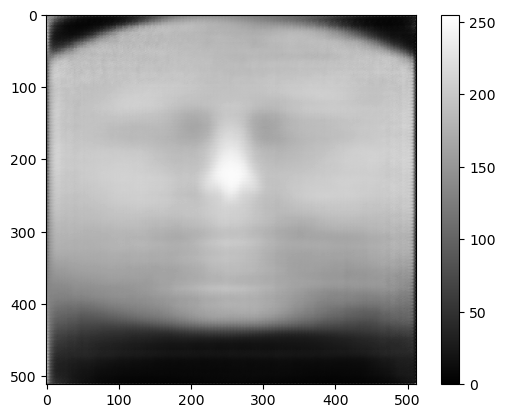

Displaying prediction_epoch_12.npy


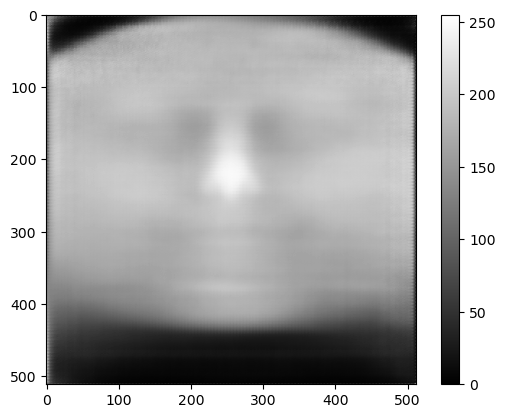

Displaying prediction_epoch_13.npy


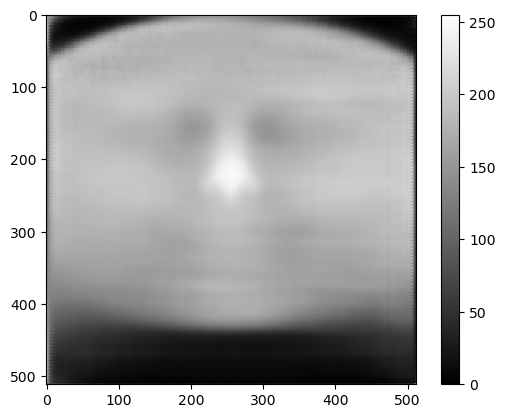

Displaying prediction_epoch_14.npy


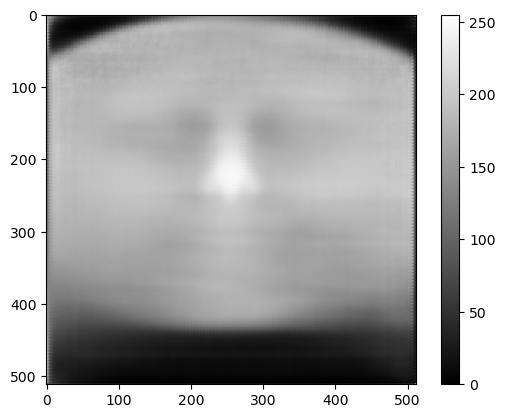

Displaying prediction_epoch_15.npy


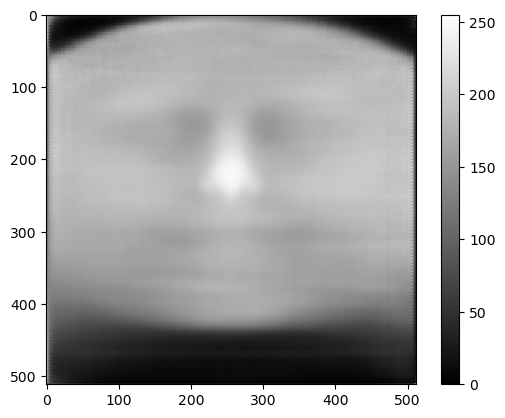

Displaying prediction_epoch_16.npy


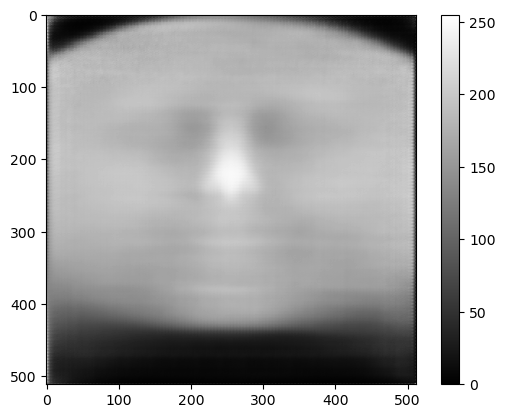

Displaying prediction_epoch_17.npy


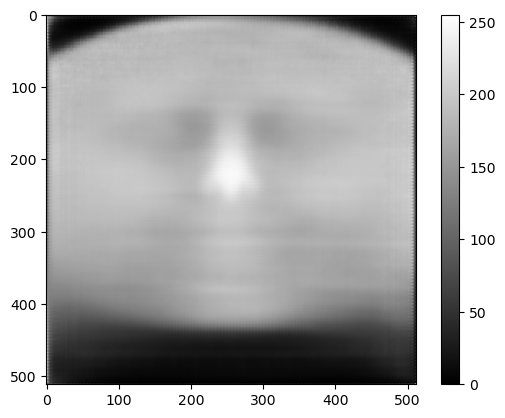

Displaying prediction_epoch_18.npy


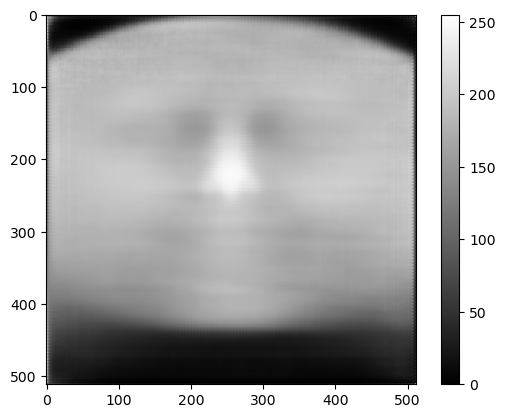

In [41]:
def process_and_display_posmap(filename):
    predicted_posmap = np.load(filename)
    predicted_posmap = predicted_posmap.squeeze()
    predicted_posmap = (predicted_posmap - predicted_posmap.min()) / (predicted_posmap.max() - predicted_posmap.min())  # Normalize to [0, 1]
    predicted_posmap = (predicted_posmap * 255).astype(np.uint8)

    plt.imshow(predicted_posmap, cmap='gray')
    plt.colorbar()
    plt.show()

# Process and display posmaps for prediction_1 through prediction_13
for i in range(1, 19):
    filename = f'prediction_epoch_{i}.npy'
    print(f"Displaying {filename}")
    process_and_display_posmap(filename)
